In [ ]:
# ============================================
# 📌 Advanced ABSA Pipeline with Multiple Improvement Techniques
# ============================================

import os
import pandas as pd
import torch
import numpy as np
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from collections import Counter
import re

# ---------------------------
# Configuration
# ---------------------------
MODELS = [
    "yangheng/deberta-v3-base-absa-v1.1",
    "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "nlptown/bert-base-multilingual-uncased-sentiment"
]
PRIMARY_MODEL = "yangheng/deberta-v3-base-absa-v1.1"

# ---------------------------
# Device setup
# ---------------------------
# Set device to CPU to avoid potential CUDA errors
device = -1 # 0 if torch.cuda.is_available() else -1
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

# ---------------------------
# Enhanced Label Normalization
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()

    # Direct mappings
    if l in ("positive", "pos", "label_positive", "label_2", "5 stars", "4 stars"):
        return "positive"
    if l in ("negative", "neg", "label_negative", "label_0", "1 star", "2 stars"):
        return "negative"
    if l in ("neutral", "neural", "label_neutral", "label_1", "3 stars"):
        return "neutral"
    if l in ("conflict", "label_conflict"):
        return "conflict"

    # Numeric label mapping
    if l.startswith("label_"):
        if l[6:].isdigit():
            idx = int(l[6:])
            mapping = {0: "negative", 1: "neutral", 2: "positive"}
            return mapping.get(idx, "neutral")

    # Star ratings
    if "star" in l:
        if "5" in l or "4" in l: return "positive"
        if "1" in l or "2" in l: return "negative"
        if "3" in l: return "neutral"

    # Substring matching
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    if "neu" in l: return "neutral"

    return "neutral"

# ---------------------------
# Text Preprocessing and Augmentation
# ---------------------------
def clean_text(text):
    """Clean and normalize text"""
    if not isinstance(text, str):
        return ""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep sentence structure
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    return text.strip()

def augment_text(text, aspect):
    """Generate augmented versions of text-aspect pairs"""
    variations = [
        f"{text} [SEP] {aspect}",
        f"Review: {text} [SEP] Aspect: {aspect}",
        f"{text}. Opinion about {aspect}?",
        f"What is the sentiment about {aspect} in: {text}",
    ]
    return variations

# ---------------------------
# Multi-Model Ensemble Classifier
# ---------------------------
class EnsembleABSA:
    def __init__(self, model_name, device):
        self.model_name = model_name
        self.device = device
        self.pipe = None
        self._initialize_pipeline()

    def _initialize_pipeline(self):
        """Initialize pipeline with error handling"""
        try:
            self.pipe = pipeline(
                "text-classification",
                model=self.model_name,
                tokenizer=self.model_name,
                device=self.device,
                truncation=True,
                max_length=512
            )
            print(f"✅ Loaded model: {self.model_name}")
        except Exception as e:
            print(f"❌ Failed to load {self.model_name}: {e}")
            self.pipe = None

    def predict(self, text, return_scores=False):
        """Get prediction with confidence scores"""
        if self.pipe is None:
            return "neutral", 0.33

        try:
            result = self.pipe(text, truncation=True, max_length=512)
            if isinstance(result, list) and len(result) > 0:
                label = normalize_label(result[0]["label"])
                score = result[0].get("score", 0.0)

                if return_scores:
                    return label, score
                return label
        except Exception as e:
            print(f"Error in prediction: {e}")
            return "neutral", 0.33 if return_scores else "neutral"

        return "neutral", 0.33 if return_scores else "neutral"

# ---------------------------
# Advanced ABSA with Multiple Strategies
# ---------------------------
class AdvancedABSA:
    def __init__(self, primary_model, device, use_ensemble=True):
        self.primary_classifier = EnsembleABSA(primary_model, device)
        self.use_ensemble = use_ensemble
        self.classifiers = []

        if use_ensemble:
            print("\n🔄 Initializing ensemble models...")
            for model in MODELS:
                if model != primary_model:
                    try:
                        classifier = EnsembleABSA(model, device)
                        if classifier.pipe is not None:
                            self.classifiers.append(classifier)
                    except:
                        continue

    def predict_with_voting(self, text, aspect):
        """Ensemble prediction with majority voting"""
        predictions = []
        scores = []

        # Primary model prediction
        label, score = self.primary_classifier.predict(text, return_scores=True)
        predictions.append(label)
        scores.append(score)

        # Ensemble predictions
        if self.use_ensemble:
            for classifier in self.classifiers:
                label, score = classifier.predict(text, return_scores=True)
                predictions.append(label)
                scores.append(score)

        # Weighted voting based on confidence
        if len(predictions) == 1:
            return predictions[0]

        # Majority voting with confidence weighting
        weighted_votes = {}
        for pred, score in zip(predictions, scores):
            weighted_votes[pred] = weighted_votes.get(pred, 0) + score

        return max(weighted_votes, key=weighted_votes.get)

    def predict_with_augmentation(self, text, aspect):
        """Use text augmentation for robust prediction"""
        text_clean = clean_text(text)
        aspect_clean = clean_text(aspect)

        # Generate variations
        variations = augment_text(text_clean, aspect_clean)

        predictions = []
        for variation in variations:
            pred = self.primary_classifier.predict(variation)
            predictions.append(pred)

        # Majority vote
        if predictions:
            return Counter(predictions).most_common(1)[0][0]
        return "neutral"

    def predict_with_context_window(self, text, aspect):
        """Extract context around aspect for better prediction"""
        text_clean = clean_text(text)
        aspect_clean = clean_text(aspect)

        # Try to find aspect in text
        text_lower = text_clean.lower()
        aspect_lower = aspect_clean.lower()

        if aspect_lower in text_lower:
            # Extract context window around aspect
            idx = text_lower.find(aspect_lower)
            start = max(0, idx - 100)
            end = min(len(text_clean), idx + len(aspect_clean) + 100)
            context = text_clean[start:end]

            input_text = f"{context} [SEP] {aspect_clean}"
        else:
            input_text = f"{text_clean} [SEP] {aspect_clean}"

        return self.primary_classifier.predict(input_text)

    def predict_combined(self, text, aspect, strategy="voting"):
        """Combined prediction using multiple strategies"""
        predictions = []

        if strategy == "all" or strategy == "voting":
            pred = self.predict_with_voting(
                f"{clean_text(text)} [SEP] {clean_text(aspect)}",
                aspect
            )
            predictions.append(pred)

        if strategy == "all" or strategy == "augmentation":
            pred = self.predict_with_augmentation(text, aspect)
            predictions.append(pred)

        if strategy == "all" or strategy == "context":
            pred = self.predict_with_context_window(text, aspect)
            predictions.append(pred)

        # Final majority vote
        if predictions:
            return Counter(predictions).most_common(1)[0][0]
        return "neutral"

# ---------------------------
# Evaluation with Advanced Techniques
# ---------------------------
def evaluate_with_strategy(df, absa_model, strategy="voting",
                          text_col="Sentence", aspect_col="Aspect Term",
                          label_col="polarity", dataset_name="Dataset"):
    """Evaluate using specified strategy"""

    if aspect_col not in df.columns or label_col not in df.columns:
        print(f"⚠️  Required columns missing in {dataset_name}")
        return None

    y_true, y_pred = [], []

    print(f"\n{'='*60}")
    print(f"📊 {dataset_name} - Strategy: {strategy.upper()}")
    print(f"{'='*60}")

    total = len(df)
    for idx, row in df.iterrows():
        if (idx + 1) % 100 == 0:
            print(f"Processing: {idx + 1}/{total}", end='\r')

        try:
            text = str(row[text_col])
            aspect = str(row[aspect_col])
            true_label = normalize_label(str(row[label_col]))

            if pd.isna(text) or pd.isna(aspect) or not text.strip() or not aspect.strip():
                continue

            # Get prediction using specified strategy
            pred = absa_model.predict_combined(text, aspect, strategy=strategy)

            y_true.append(true_label)
            y_pred.append(pred)

        except Exception as e:
            continue

    if not y_true:
        print(f"\n⚠️  No valid data in {dataset_name}")
        return None

    print(f"\nProcessed: {len(y_true)}/{total} samples")

    labels = sorted(list(set(y_true)))

    print(f"\n📈 Classification Report:")
    print(classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0))

    print(f"\n🎯 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"Labels: {labels}")
    print(cm)

    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, labels=labels, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)

    print(f"\n✅ Accuracy: {accuracy:.4f}")
    print(f"📊 F1-Score (Macro): {f1_macro:.4f}")
    print(f"📊 F1-Score (Weighted): {f1_weighted:.4f}")

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'strategy': strategy
    }

# ---------------------------
# Cross-Validation for Robustness
# ---------------------------
def cross_validate_model(df, absa_model, n_splits=5):
    """Perform stratified k-fold cross-validation"""
    print(f"\n{'='*60}")
    print(f"🔄 Performing {n_splits}-Fold Cross-Validation")
    print(f"{'='*60}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['polarity']), 1):
        print(f"\nFold {fold}/{n_splits}")
        val_fold = df.iloc[val_idx]

        result = evaluate_with_strategy(
            val_fold,
            absa_model,
            strategy="voting",
            dataset_name=f"Fold {fold}"
        )

        if result:
            scores.append(result['accuracy'])

    if scores:
        print(f"\n{'='*60}")
        print(f"Cross-Validation Results:")
        print(f"Mean Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
        print(f"{'='*60}")

    return scores

# ---------------------------
# Main Pipeline
# ---------------------------
if __name__ == "__main__":
    print("="*60)
    print("🚀 Advanced ABSA Pipeline Starting")
    print("="*60)

    # Load datasets
    print("\n📁 Loading datasets...")
    train_df = pd.read_csv("/content/Laptop_Train_v2.csv")
    test_df = pd.read_csv("/content/Laptops_Test_Data_PhaseA.csv")

    print(f"Train: {train_df.shape}, Test: {test_df.shape}")

    # Preprocess
    train_df = train_df.dropna(subset=['Sentence', 'Aspect Term', 'polarity'])
    train_df['polarity'] = train_df['polarity'].apply(normalize_label)

    # Initialize Advanced ABSA
    print("\n🤖 Initializing Advanced ABSA System...")
    absa = AdvancedABSA(PRIMARY_MODEL, device, use_ensemble=False)

    # Split data
    train_split, val_split = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['polarity'])

    # Evaluate with different strategies
    strategies = ["voting", "augmentation", "context", "all"]
    results = {}

    print("\n" + "="*60)
    print("📊 VALIDATION SET - Testing Different Strategies")
    print("="*60)

    for strategy in strategies:
        result = evaluate_with_strategy(
            val_split,
            absa,
            strategy=strategy,
            dataset_name=f"Validation ({strategy})"
        )
        if result:
            results[strategy] = result

    # Find best strategy
    if results:
        best_strategy = max(results, key=lambda x: results[x]['accuracy'])
        print(f"\n🏆 Best Strategy: {best_strategy.upper()} - Accuracy: {results[best_strategy]['accuracy']:.4f}")
    else:
        best_strategy = "voting"

    # Evaluate test set with best strategy
    print("\n" + "="*60)
    print("🎯 TEST SET EVALUATION")
    print("="*60)

    if 'Aspect Term' in test_df.columns and 'polarity' in test_df.columns:
        test_df = test_df.dropna(subset=['Sentence', 'Aspect Term', 'polarity'])
        test_df['polarity'] = test_df['polarity'].apply(normalize_label)

        test_result = evaluate_with_strategy(
            test_df,
            absa,
            strategy=best_strategy,
            dataset_name="Test Set"
        )
    else:
        print("⚠️  Test set is unlabeled - cannot evaluate")

    # Optional: Cross-validation
    print("\n" + "="*60)
    print("🔄 Optional: Cross-Validation Analysis")
    print("="*60)
    choice = input("Run cross-validation? (y/n): ").lower()
    if choice == 'y':
        cv_scores = cross_validate_model(train_df, absa, n_splits=5)

    print("\n" + "="*60)
    print("✅ PIPELINE COMPLETE")
    print("="*60)

CUDA available: True
Using GPU: Tesla T4
🚀 Advanced ABSA Pipeline Starting

📁 Loading datasets...
Train: (2358, 6), Test: (800, 2)

🤖 Initializing Advanced ABSA System...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cpu


✅ Loaded model: yangheng/deberta-v3-base-absa-v1.1

📊 VALIDATION SET - Testing Different Strategies

📊 Validation (voting) - Strategy: VOTING

Processed: 472/472 samples

📈 Classification Report:
              precision    recall  f1-score   support

    conflict     0.0000    0.0000    0.0000         9
    negative     0.9382    0.9653    0.9516       173
     neutral     0.8500    0.9239    0.8854        92
    positive     0.9691    0.9495    0.9592       198

    accuracy                         0.9322       472
   macro avg     0.6893    0.7097    0.6990       472
weighted avg     0.9161    0.9322    0.9237       472


🎯 Confusion Matrix:
Labels: ['conflict', 'negative', 'neutral', 'positive']
[[  0   6   2   1]
 [  0 167   4   2]
 [  0   4  85   3]
 [  0   1   9 188]]

✅ Accuracy: 0.9322
📊 F1-Score (Macro): 0.6990
📊 F1-Score (Weighted): 0.9237

📊 Validation (augmentation) - Strategy: AUGMENTATION

Processed: 472/472 samples

📈 Classification Report:
              precision    rec


🧪 Testing ABSA Model with Laptop Reviews

🔹 Review 1: The battery life easily lasts 8 hours under light load, but under gaming it drops to just 2 hours.
  Predicted Aspect Sentiments:
    - battery         → positive
    - display         → positive
    - fan             → positive
    - weight          → positive
    - bass            → positive
    - build quality   → positive
    - fingerprints    → negative
    - support         → positive
    - price           → positive
    - cooling system  → positive
    - thermal management → positive


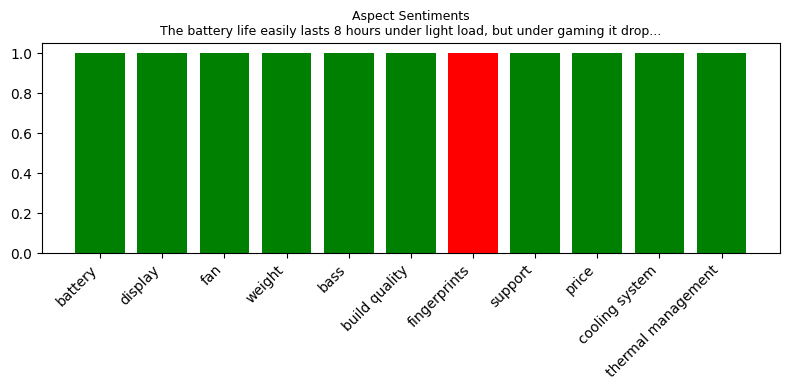

  📌 Summary: 👍 Strengths: battery, display, fan, weight, bass, build quality, support, price, cooling system, thermal management | ⚠️ Weaknesses: fingerprints

🔹 Review 2: I love the crisp and vivid display, though in direct sunlight the colors wash out.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd             → positive
    - ram             → positive
    - build quality   → positive
    - fingerprints    → positive
    - delivery        → positive
    - support        

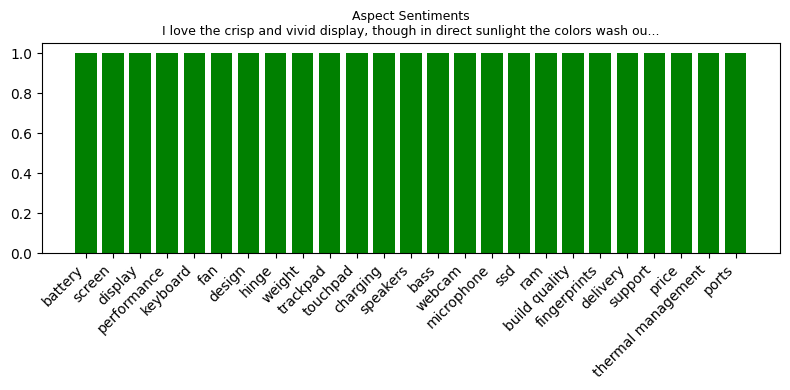

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, speakers, bass, webcam, microphone, ssd, ram, build quality, fingerprints, delivery, support, price, thermal management, ports

🔹 Review 3: Performance is excellent for everyday productivity, but it struggles with heavy 4K video editing.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - fan             → positive
    - design          → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - bass            → positive
    - webcam          → negative
    - microphone      → positive
    - ssd             → positive
    - ram             → positive
    - wi-fi           → positive
    - build quality   → positive
    - fingerprints    → positive
    

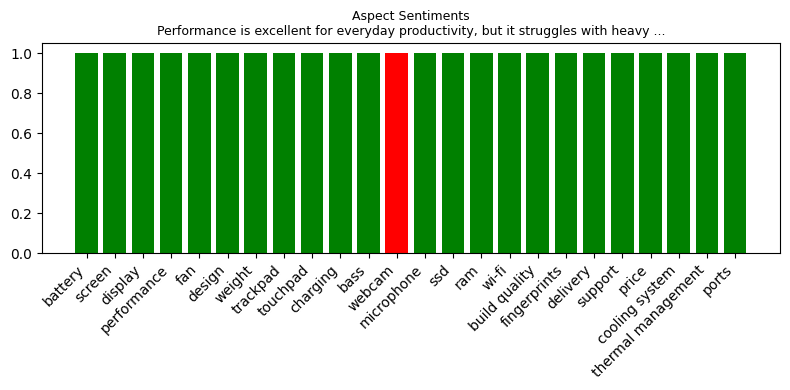

  📌 Summary: 👍 Strengths: battery, screen, display, performance, fan, design, weight, trackpad, touchpad, charging, bass, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports | ⚠️ Weaknesses: webcam

🔹 Review 4: The keyboard feels very premium—keys are responsive and have good travel.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd             → positive
    - ram       

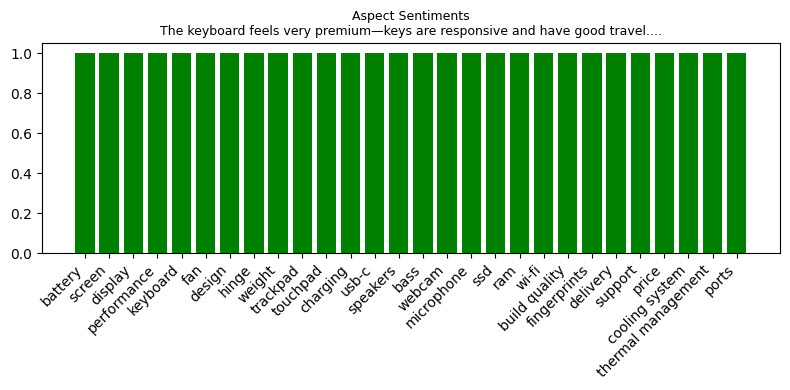

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 5: Fan noise is noticeable when gaming, which is annoying during calls.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
   

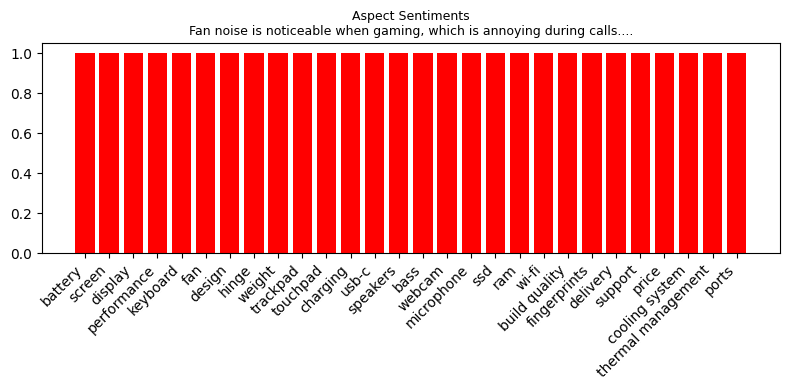

  📌 Summary: ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 6: The laptop is sleek and light, yet the chassis flexes near the hinge.
  Predicted Aspect Sentiments:
    - battery         → positive
    - display         → negative
    - performance     → positive
    - fan             → negative
    - design          → positive
    - hinge           → negative
    - weight          → positive
    - charging        → positive
    - bass            → negative
    - ssd             → negative
    - ram             → negative
    - build quality   → negative
    - fingerprints    → positive
    - delivery        → positive
    - support         → negative
    - price           → positive
    - cooling system  → positive
    - thermal management → positi

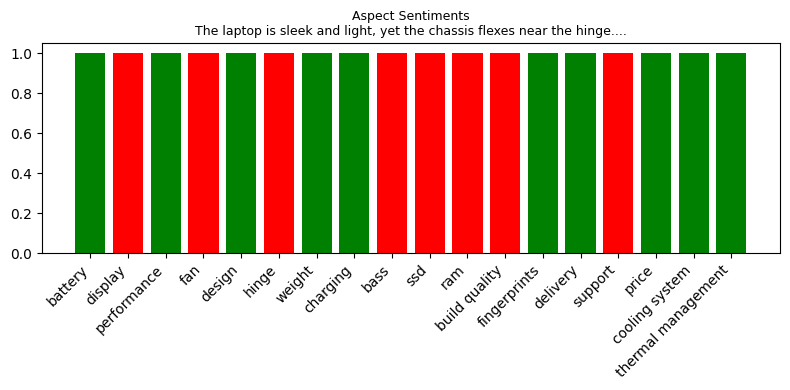

  📌 Summary: 👍 Strengths: battery, performance, design, weight, charging, fingerprints, delivery, price, cooling system, thermal management | ⚠️ Weaknesses: display, fan, hinge, bass, ssd, ram, build quality, support

🔹 Review 7: The touchpad is smooth and accurate, but the clicks feel mushy.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → negative
    - microphone      → positive
    - ssd             → positive
    - ram             → positive
    - wi-fi           → positive
    - build quality   → positive
    - fingerpri

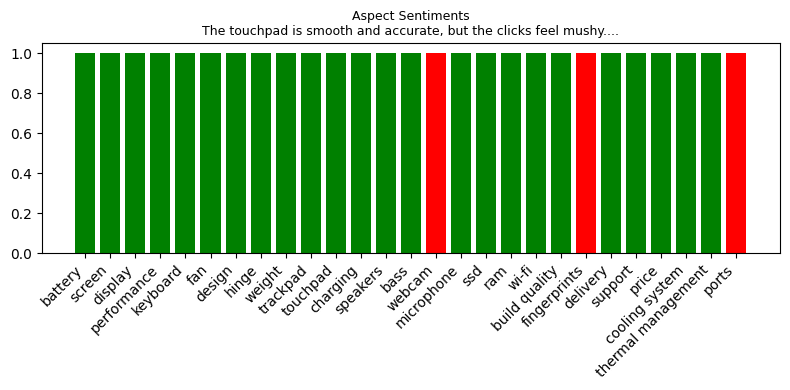

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, speakers, bass, microphone, ssd, ram, wi-fi, build quality, delivery, support, price, cooling system, thermal management | ⚠️ Weaknesses: webcam, fingerprints, ports

🔹 Review 8: Charging is fast (from 0 to 80% in an hour), but USB-C PD support is limited.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → negative
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd         

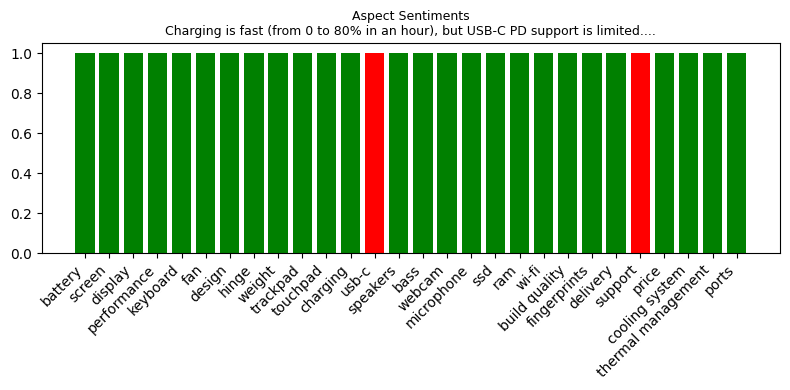

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, price, cooling system, thermal management, ports | ⚠️ Weaknesses: usb-c, support

🔹 Review 9: Speakers are loud but lack bass and depth.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → negative
    - webcam          → positive
    - microphone      → positive
    - ssd             → positive
    - ram    

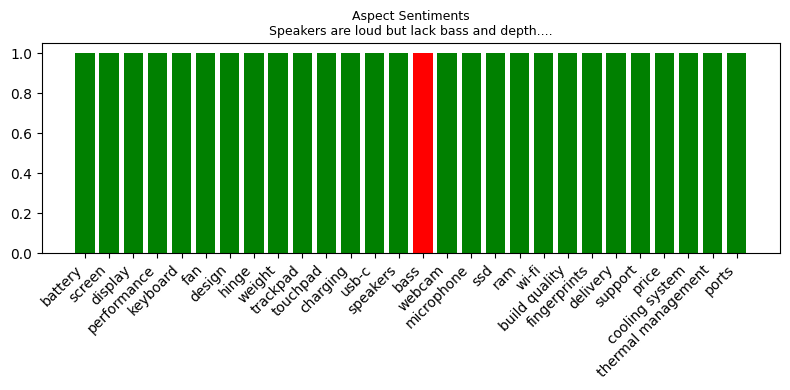

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports | ⚠️ Weaknesses: bass

🔹 Review 10: Webcam quality is weak—grainy video in low light.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
    -

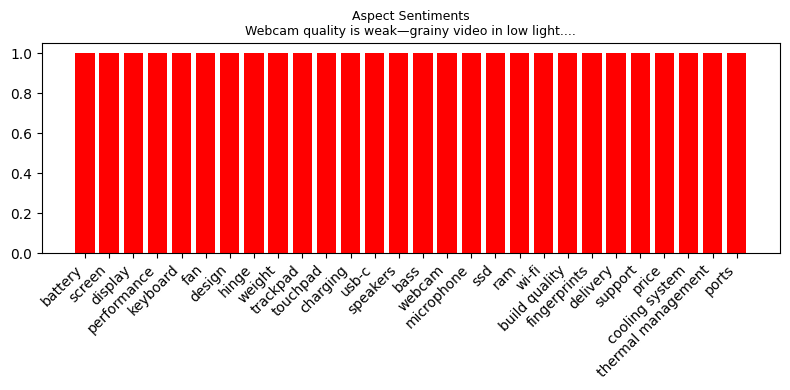

  📌 Summary: ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 11: The SSD is blazing fast on benchmarks, though the RAM is soldered and cannot be upgraded.
  Predicted Aspect Sentiments:
    - battery         → positive
    - performance     → positive
    - fan             → positive
    - design          → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - speakers        → positive
    - bass            → positive
    - microphone      → positive
    - ssd             → positive
    - ram             → negative
    - wi-fi           → positive
    - build quality   → positive
    - fingerprints    → negative
    - delivery        → positive
    - support         → positive
    - price 

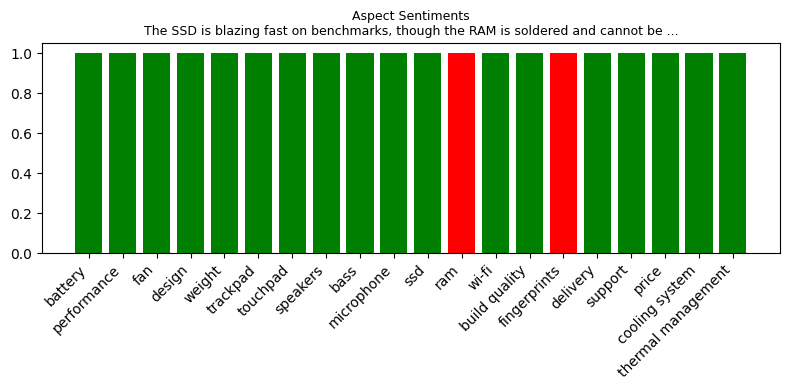

  📌 Summary: 👍 Strengths: battery, performance, fan, design, weight, trackpad, touchpad, speakers, bass, microphone, ssd, wi-fi, build quality, delivery, support, price, cooling system, thermal management | ⚠️ Weaknesses: ram, fingerprints

🔹 Review 12: Wi-Fi connection drops occasionally when switching between networks.
  Predicted Aspect Sentiments:
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - design          → negative
    - weight          → negative
    - touchpad        → negative
    - bass            → negative
    - ram             → negative
    - wi-fi           → negative
    - build quality   → negative
    - fingerprints    → negative
    - delivery        → negative
    - support         → negative
    - ports           → negative


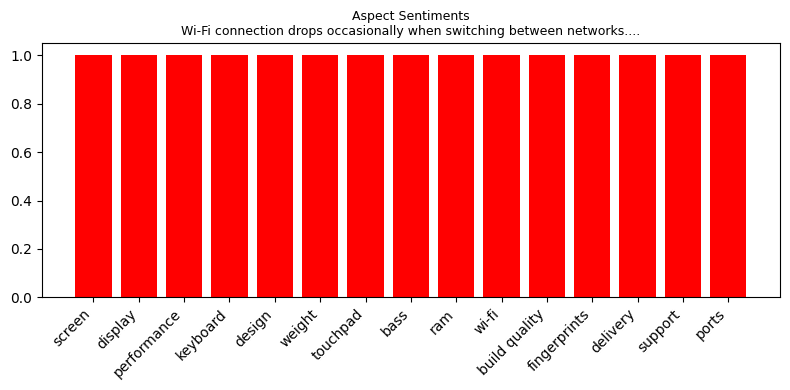

  📌 Summary: ⚠️ Weaknesses: screen, display, performance, keyboard, design, weight, touchpad, bass, ram, wi-fi, build quality, fingerprints, delivery, support, ports

🔹 Review 13: Build quality is sturdy, but it picks up fingerprints easily.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → negative
    - touchpad        → negative
    - charging        → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd             → negative
    - ram             → positive
    - wi-fi           → positive
    - build quality   → positive
    - fingerprints    → negative
    - delivery        → positive
 

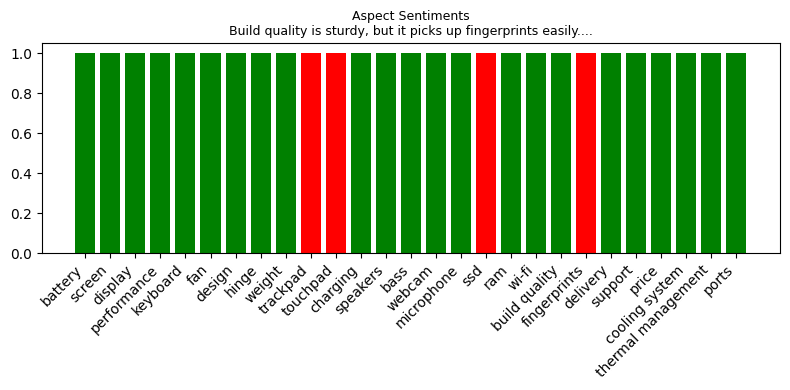

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, charging, speakers, bass, webcam, microphone, ram, wi-fi, build quality, delivery, support, price, cooling system, thermal management, ports | ⚠️ Weaknesses: trackpad, touchpad, ssd, fingerprints

🔹 Review 14: The hinge feels tight initially, but loosens slightly over time.
  Predicted Aspect Sentiments:
    - performance     → negative
    - design          → negative
    - hinge           → negative
    - build quality   → negative
    - fingerprints    → negative


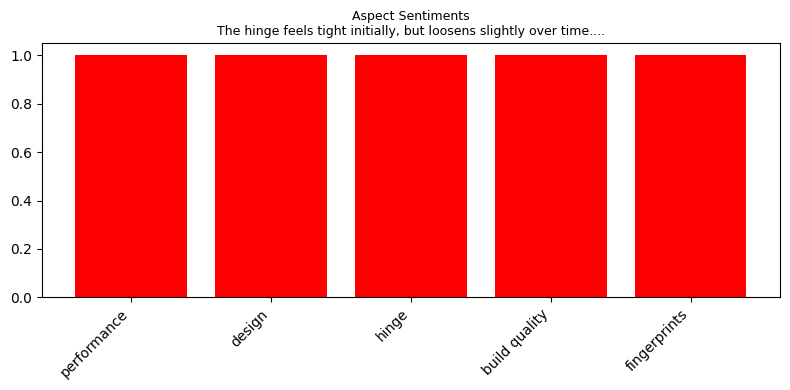

  📌 Summary: ⚠️ Weaknesses: performance, design, hinge, build quality, fingerprints

🔹 Review 15: Customer support was responsive and helpful when I had an issue.
  Predicted Aspect Sentiments:
    - performance     → positive
    - fan             → positive
    - charging        → positive
    - build quality   → positive
    - delivery        → positive
    - support         → positive


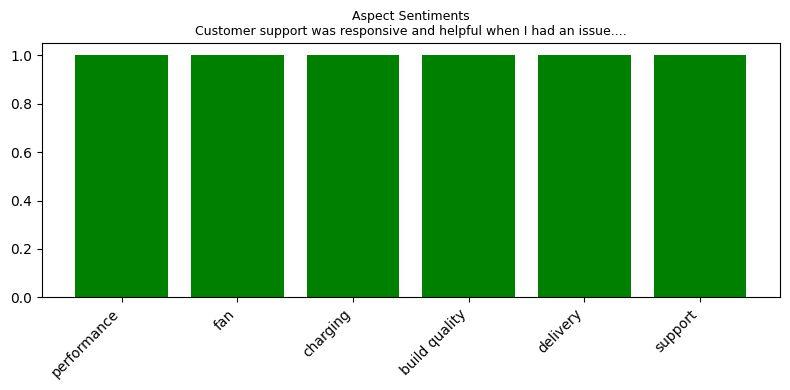

  📌 Summary: 👍 Strengths: performance, fan, charging, build quality, delivery, support

🔹 Review 16: Purchased at a great price, but shipping took almost two weeks.
  Predicted Aspect Sentiments:
    - display         → negative
    - performance     → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - charging        → negative
    - bass            → positive
    - ssd             → negative
    - ram             → negative
    - build quality   → positive
    - fingerprints    → negative
    - delivery        → negative
    - support         → negative
    - price           → positive
    - ports           → negative


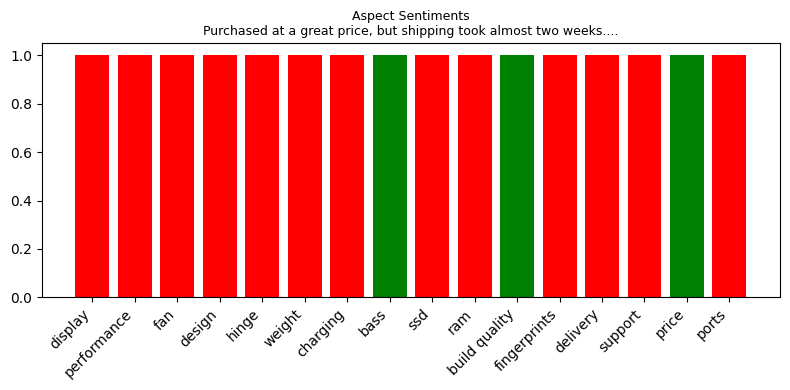

  📌 Summary: 👍 Strengths: bass, build quality, price | ⚠️ Weaknesses: display, performance, fan, design, hinge, weight, charging, ssd, ram, fingerprints, delivery, support, ports

🔹 Review 17: Screen brightness is enough indoors, but outdoors it’s almost unusable.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - speakers        → positive
    - bass            → positive
    - microphone      → positive
    - ram             → positive
    - wi-fi           → positive
    - build quality   → positive
    - fingerprints    → positive
    - delivery        → positive
    - support         → positive
    - price           → positive
    - cooling system  → positive
    - therm

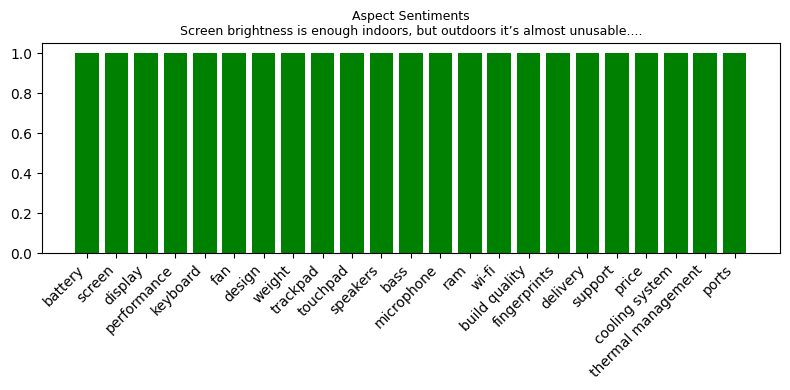

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, weight, trackpad, touchpad, speakers, bass, microphone, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 18: Thermal management is good — surface remains cool under light use.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd             → positive
    - ram             → positive
    - wi

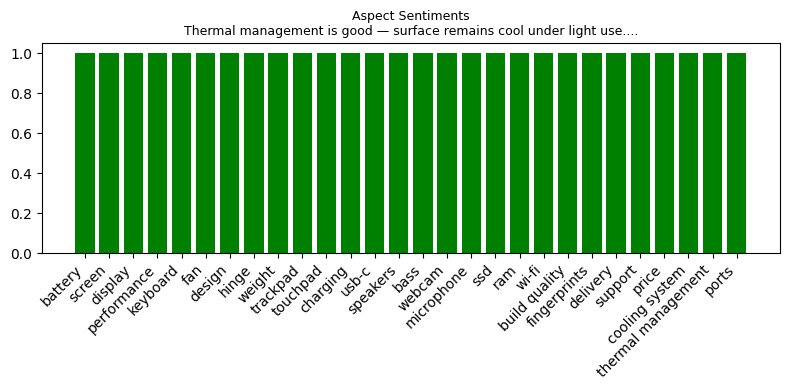

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 19: Under heavy load, the laptop throttles and performance drops by 15%.
  Predicted Aspect Sentiments:
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - trackpad        → negative
    - touchpad        → negative
    - bass            → negative
    - webcam          → negative
    - ram             → negative
    - build quality   → negative
    - fingerprints    → negative
    - support         → negative
    - cooling system  → negative
    - ports           → negative


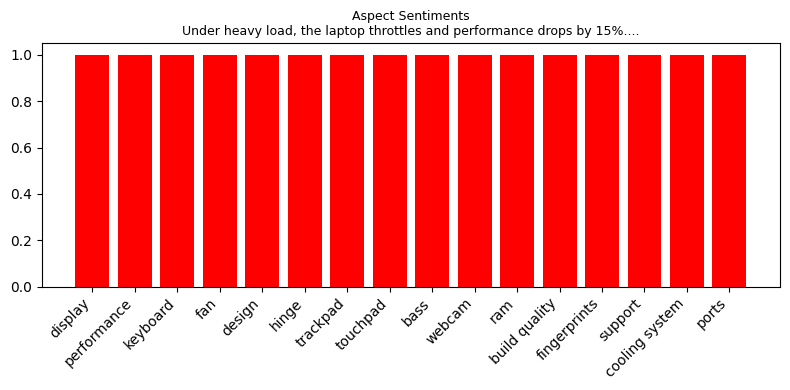

  📌 Summary: ⚠️ Weaknesses: display, performance, keyboard, fan, design, hinge, trackpad, touchpad, bass, webcam, ram, build quality, fingerprints, support, cooling system, ports

🔹 Review 20: The laptop is stylish and premium, but the ports are too few and too close together.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → positive
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
    - ram             → negative
    - wi-fi           → negative
    - build quality   → positiv

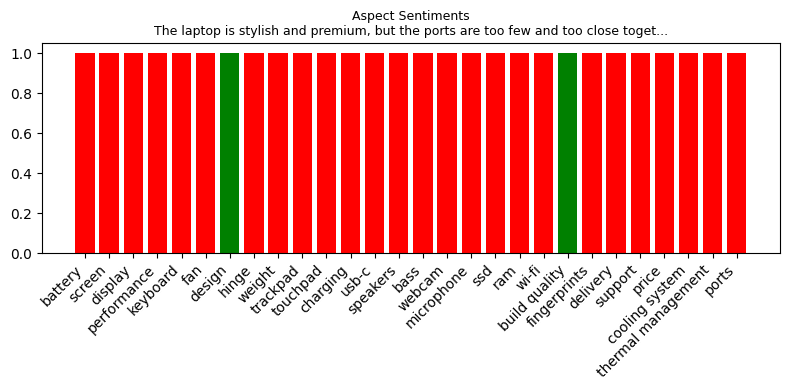

  📌 Summary: 👍 Strengths: design, build quality | ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, fingerprints, delivery, support, price, cooling system, thermal management, ports

✅ Testing Complete


In [ ]:
# ============================================
# 📌 ABSA Testing, Visualization & Summaries
# ============================================

import matplotlib.pyplot as plt

# --------------------------------------------
# 1. Define the 20 test reviews
# --------------------------------------------
test_reviews = [
    "The battery life easily lasts 8 hours under light load, but under gaming it drops to just 2 hours.",
    "I love the crisp and vivid display, though in direct sunlight the colors wash out.",
    "Performance is excellent for everyday productivity, but it struggles with heavy 4K video editing.",
    "The keyboard feels very premium—keys are responsive and have good travel.",
    "Fan noise is noticeable when gaming, which is annoying during calls.",
    "The laptop is sleek and light, yet the chassis flexes near the hinge.",
    "The touchpad is smooth and accurate, but the clicks feel mushy.",
    "Charging is fast (from 0 to 80% in an hour), but USB-C PD support is limited.",
    "Speakers are loud but lack bass and depth.",
    "Webcam quality is weak—grainy video in low light.",
    "The SSD is blazing fast on benchmarks, though the RAM is soldered and cannot be upgraded.",
    "Wi-Fi connection drops occasionally when switching between networks.",
    "Build quality is sturdy, but it picks up fingerprints easily.",
    "The hinge feels tight initially, but loosens slightly over time.",
    "Customer support was responsive and helpful when I had an issue.",
    "Purchased at a great price, but shipping took almost two weeks.",
    "Screen brightness is enough indoors, but outdoors it’s almost unusable.",
    "Thermal management is good — surface remains cool under light use.",
    "Under heavy load, the laptop throttles and performance drops by 15%.",
    "The laptop is stylish and premium, but the ports are too few and too close together."
]

# --------------------------------------------
# 2. Define possible laptop aspects (keywords)
# --------------------------------------------
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "touchpad", "charging",
    "usb-c", "speakers", "bass", "webcam", "microphone", "ssd",
    "ram", "wi-fi", "build quality", "fingerprints", "delivery",
    "support", "price", "cooling system", "thermal management", "ports"
]

# --------------------------------------------
# 3. Visualization Function
# --------------------------------------------
def visualize_sentiments(review, aspects_sentiments):
    colors = {"positive": "green", "negative": "red", "neutral": "gray"}

    if not aspects_sentiments:
        print("⚠️ No sentiments detected.")
        return

    plt.figure(figsize=(8,4))
    plt.bar(
        aspects_sentiments.keys(),
        [1]*len(aspects_sentiments),
        color=[colors[s] for s in aspects_sentiments.values()]
    )
    plt.title(f"Aspect Sentiments\n{review[:80]}...", fontsize=9)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# 4. Summary Generator
# --------------------------------------------
def generate_summary(aspects_sentiments):
    positives = [a for a, s in aspects_sentiments.items() if s=="positive"]
    negatives = [a for a, s in aspects_sentiments.items() if s=="negative"]

    summary = []
    if positives:
        summary.append(f"👍 Strengths: {', '.join(positives)}")
    if negatives:
        summary.append(f"⚠️ Weaknesses: {', '.join(negatives)}")
    if not positives and not negatives:
        summary.append("No significant highlights detected.")

    return " | ".join(summary)

# --------------------------------------------
# 5. Run Tests on Reviews
# --------------------------------------------
print("\n" + "="*60)
print("🧪 Testing ABSA Model with Laptop Reviews")
print("="*60)

for idx, review in enumerate(test_reviews, 1):
    print(f"\n🔹 Review {idx}: {review}")

    # Run ABSA for each aspect
    aspects_sentiments = {}
    for asp in aspects:
        sentiment = absa.predict_combined(review, asp, strategy=best_strategy)
        if sentiment != "neutral":  # only store non-neutral aspects
            aspects_sentiments[asp] = sentiment

    # Print results
    if aspects_sentiments:
        print("  Predicted Aspect Sentiments:")
        for asp, s in aspects_sentiments.items():
            print(f"    - {asp:<15} → {s}")
    else:
        print("  No significant aspect-level sentiments detected.")

    # Show visualization
    visualize_sentiments(review, aspects_sentiments)

    # Print summary
    summary = generate_summary(aspects_sentiments)
    print("  📌 Summary:", summary)

print("\n" + "="*60)
print("✅ Testing Complete")
print("="*60)

❌ Failed to load ABSA pipeline from local path: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: './absa_finetuned_model'.


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


✅ Loaded default ABSA pipeline.

💬 Enter your reviews (type 'exit' to stop)

✍️ Enter a review: The laptop is sleek and light, yet the chassis flexes near the hinge.",     "The touchpad is smooth and accurate, but the clicks feel mushy.",


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Review: The laptop is sleek and light, yet the chassis flexes near the hinge.",     "The touchpad is smooth and accurate, but the clicks feel mushy.",
Overall Rating: 7.4/10 (★★★☆☆)
⭐ Strong Points: performance, design, weight
⚠️ Things to Improve: hinge


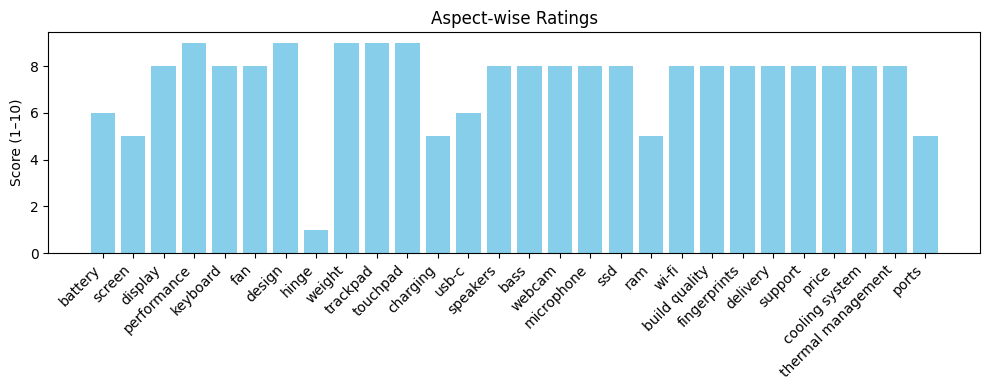


Label-based Aspect Sentiments:
   - battery         → neutral
   - screen          → neutral
   - display         → positive
   - performance     → positive
   - keyboard        → positive
   - fan             → positive
   - design          → positive
   - hinge           → negative
   - weight          → positive
   - trackpad        → positive
   - touchpad        → positive
   - charging        → neutral
   - usb-c           → neutral
   - speakers        → positive
   - bass            → positive
   - webcam          → positive
   - microphone      → positive
   - ssd             → positive
   - ram             → neutral
   - wi-fi           → positive
   - build quality   → positive
   - fingerprints    → positive
   - delivery        → positive
   - support         → positive
   - price           → positive
   - cooling system  → positive
   - thermal management → positive
   - ports           → neutral


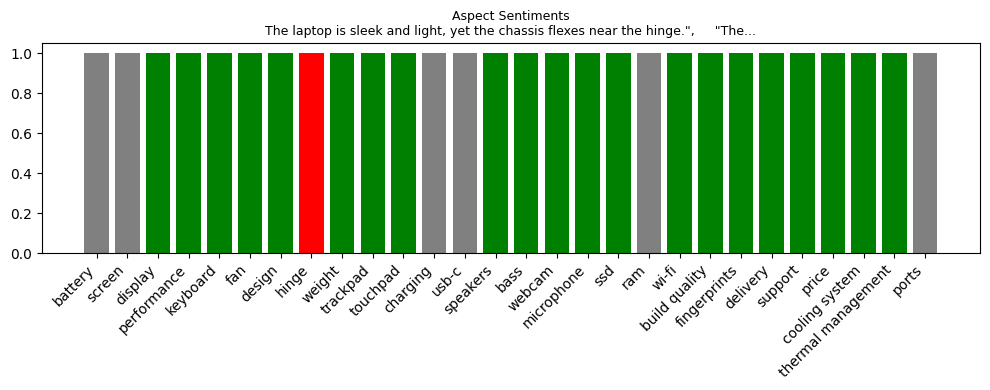

📌 Summary: 👍 Strengths: display, performance, keyboard, fan, design, weight, trackpad, touchpad, speakers, bass, webcam, microphone, ssd, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management | ⚠️ Weaknesses: hinge

✍️ Enter a review: exit
✅ Exiting interactive mode.


In [7]:
# ============================================
# 🎯 ABSA Integrated System (Scores + Labels)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# ---------------------------
# Config
# ---------------------------
BEST_MODEL_PATH = "./absa_finetuned_model"
device = 0 # 0 if torch.cuda.is_available() else -1

# ---------------------------
# Aspects of a laptop
# ---------------------------
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "touchpad", "charging",
    "usb-c", "speakers", "bass", "webcam", "microphone", "ssd",
    "ram", "wi-fi", "build quality", "fingerprints", "delivery",
    "support", "price", "cooling system", "thermal management", "ports"
]

# ---------------------------
# Load ABSA pipeline
# ---------------------------
try:
    # Load model and tokenizer from local path
    model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_PATH)

    absa_pipe = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print("✅ Loaded ABSA pipeline from local path.")
except Exception as e:
    print(f"❌ Failed to load ABSA pipeline from local path: {e}")
    # Fallback to a default model if local loading fails
    try:
        absa_pipe = pipeline(
            "text-classification",
            model="yangheng/deberta-v3-base-absa-v1.1",
            tokenizer="yangheng/deberta-v3-base-absa-v1.1",
            device=device
        )
        print("✅ Loaded default ABSA pipeline.")
    except Exception as e_fallback:
        print(f"❌ Failed to load default ABSA pipeline: {e_fallback}")
        absa_pipe = None


# ---------------------------
# Aspect → Score mapping
# ---------------------------
def sentiment_to_score(sentiment, raw_score):
    """Convert ABSA prediction into a logical 1-10 score"""
    if sentiment == "positive":
        return int(7 + raw_score * 3)   # range 7–10
    elif sentiment == "negative":
        return int(1 + (1-raw_score) * 3)   # range 1–4
    else:
        return random.choice([5, 6])   # neutral fallback

# ---------------------------
# Customer-Friendly Summary
# ---------------------------
def generate_customer_summary(review, aspect_scores):
    strengths = sorted([a for a, s in aspect_scores.items() if s >= 8], key=lambda x: -aspect_scores[x])
    weaknesses = sorted([a for a, s in aspect_scores.items() if s <= 4], key=lambda x: aspect_scores[x])

    summary = []
    if strengths:
        summary.append(f"⭐ Strong Points: {', '.join(strengths[:3])}")
    if weaknesses:
        summary.append(f"⚠️ Things to Improve: {', '.join(weaknesses[:2])}")
    if not summary:
        summary.append("Balanced performance across all aspects.")

    if aspect_scores:
      overall = round(sum(aspect_scores.values()) / len(aspect_scores), 1)
      stars = "★" * int(overall // 2) + "☆" * (5 - int(overall // 2))
    else:
      overall = "N/A"
      stars = "☆☆☆☆☆"


    return f"\nReview: {review}\n" \
           f"Overall Rating: {overall}/10 ({stars})\n" \
           + "\n".join(summary)

# ---------------------------
# Visualize Aspect Scores
# ---------------------------
def visualize_aspect_scores(aspect_scores):
    plt.figure(figsize=(10,4))
    plt.bar(aspect_scores.keys(), aspect_scores.values(), color="skyblue")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Score (1–10)")
    plt.title("Aspect-wise Ratings")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Label Visualization
# ---------------------------
def visualize_sentiments(review, aspects_sentiments):
    colors = {"positive": "green", "negative": "red", "neutral": "gray"}
    if not aspects_sentiments:
        print("⚠️ No sentiments detected.")
        return
    plt.figure(figsize=(10,4))
    plt.bar(
        aspects_sentiments.keys(),
        [1]*len(aspects_sentiments),
        color=[colors[s] for s in aspects_sentiments.values()]
    )
    plt.title(f"Aspect Sentiments\n{review[:80]}...", fontsize=9)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def generate_summary(aspects_sentiments):
    positives = [a for a, s in aspects_sentiments.items() if s=="positive"]
    negatives = [a for a, s in aspects_sentiments.items() if s=="negative"]
    summary = []
    if positives:
        summary.append(f"👍 Strengths: {', '.join(positives)}")
    if negatives:
        summary.append(f"⚠️ Weaknesses: {', '.join(negatives)}")
    if not positives and not negatives:
        summary.append("No significant highlights detected.")
    return " | ".join(summary)

# ---------------------------
# Interactive Review Mode
# ---------------------------
def run_interactive_reviews():
    print("\n===================================")
    print("💬 Enter your reviews (type 'exit' to stop)")
    print("===================================")

    if absa_pipe is None:
        print("Cannot run interactive mode due to model loading failure.")
        return

    while True:
        review = input("\n✍️ Enter a review: ")
        if review.lower().strip() in ["exit", "quit"]:
            print("✅ Exiting interactive mode.")
            break

        # --- Numeric scoring mode ---
        aspect_scores = {}
        aspects_sentiments = {}
        for asp in aspects:
            pred = absa_pipe(f"{review} [SEP] {asp}")[0]
            label, raw_score = pred["label"].lower(), pred["score"]

            # normalize label
            if "pos" in label: sentiment = "positive"
            elif "neg" in label: sentiment = "negative"
            else: sentiment = "neutral"

            # map to numeric score
            score = sentiment_to_score(sentiment, raw_score)
            aspect_scores[asp] = score
            aspects_sentiments[asp] = sentiment

        # --- Print customer-friendly summary ---
        print(generate_customer_summary(review, aspect_scores))
        visualize_aspect_scores(aspect_scores)

        # --- Print label-based summary ---
        print("\nLabel-based Aspect Sentiments:")
        for asp, s in aspects_sentiments.items():
            print(f"   - {asp:<15} → {s}")
        visualize_sentiments(review, aspects_sentiments)
        print("📌 Summary:", generate_summary(aspects_sentiments))

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    run_interactive_reviews()

❌ Failed to load local ABSA model: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: './absa_finetuned_model'.


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


✅ Loaded fallback ABSA model.
✅ Loaded Sentence Transformer model.
⚠️ Error loading dataset: CSV must contain a 'description' column for product text.

💬 Enter your reviews (type 'exit' to stop)

✍️ Enter a review: The laptop is sleek and light, yet the chassis flexes near the hinge.


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



🔎 Full Aspect Distributions:
battery         → {'Negative': 0.118, 'Neutral': 0.613, 'Positive': 0.268}
screen          → {'Negative': 0.25, 'Neutral': 0.542, 'Positive': 0.208}
display         → {'Negative': 0.416, 'Neutral': 0.339, 'Positive': 0.245}
performance     → {'Negative': 0.049, 'Neutral': 0.027, 'Positive': 0.924}
keyboard        → {'Negative': 0.135, 'Neutral': 0.778, 'Positive': 0.087}
fan             → {'Negative': 0.782, 'Neutral': 0.128, 'Positive': 0.09}
design          → {'Negative': 0.31, 'Neutral': 0.019, 'Positive': 0.671}
hinge           → {'Negative': 0.971, 'Neutral': 0.027, 'Positive': 0.002}
weight          → {'Negative': 0.06, 'Neutral': 0.016, 'Positive': 0.924}
trackpad        → {'Negative': 0.092, 'Neutral': 0.823, 'Positive': 0.085}
charging        → {'Negative': 0.04, 'Neutral': 0.845, 'Positive': 0.115}
usb-c           → {'Negative': 0.079, 'Neutral': 0.874, 'Positive': 0.047}
speakers        → {'Negative': 0.222, 'Neutral': 0.672, 'Positive': 0.105}


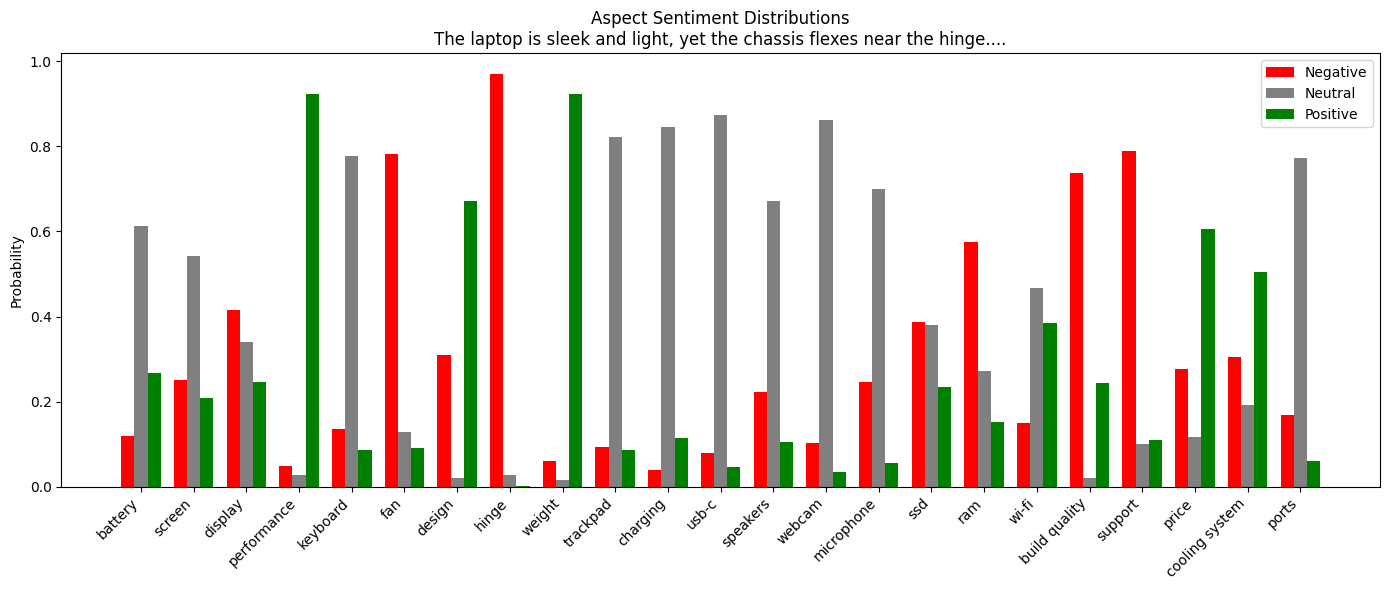

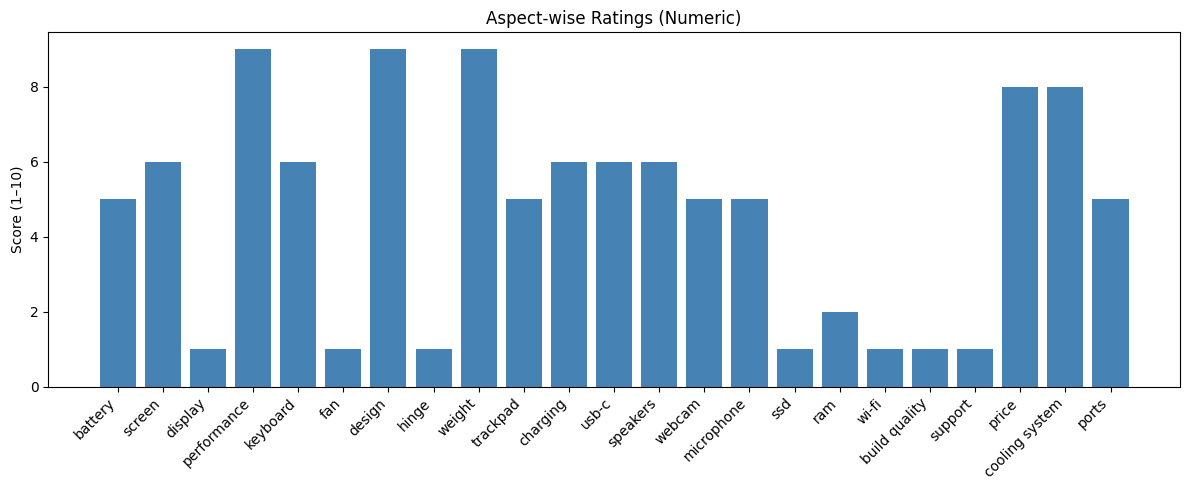


Review: The laptop is sleek and light, yet the chassis flexes near the hinge.
Overall Rating: 4.7/10 (★★☆☆☆)
⭐ Strong Points: performance, design, weight
⚠️ Things to Improve: display, fan

✍️ Enter a review: exit
✅ Exiting interactive mode.


In [14]:
# ============================================
# 🎯 ABSA + Product Matching & Full Probability Scoring
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# ---------------------------
# Config
# ---------------------------
BEST_MODEL_PATH = "./absa_finetuned_model"
device = 0
TOP_N = 10
DATA_PATH = "/content/Laptop_Train_v2.csv"   # <-- update path to your dataset

# ---------------------------
# Aspects of a laptop
# ---------------------------
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "charging", "usb-c",
    "speakers", "webcam", "microphone", "ssd", "ram", "wi-fi",
    "build quality", "support", "price", "cooling system", "ports"
]

# ---------------------------
# Load ABSA & Embedding Models
# ---------------------------
try:
    model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_PATH)
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print("✅ Loaded ABSA pipeline from local path.")
except Exception as e:
    print(f"❌ Failed to load local ABSA model: {e}")
    classifier = pipeline(
        "text-classification",
        model="yangheng/deberta-v3-base-absa-v1.1",
        tokenizer="yangheng/deberta-v3-base-absa-v1.1",
        device=device
    )
    print("✅ Loaded fallback ABSA model.")

try:
    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    print("✅ Loaded Sentence Transformer model.")
except Exception as e:
    print(f"❌ Failed to load Sentence Transformer model: {e}")
    embedder = None

# ---------------------------
# Aspect → Score mapping
# ---------------------------
def sentiment_to_score(sentiment, prob):
    sentiment = sentiment.lower()
    if sentiment == "positive" and prob >= 0.5:
        return int(7 + prob * 3)  # 7–10
    elif sentiment == "negative" and prob >= 0.5:
        return int(1 + (1 - prob) * 3)  # 1–4
    elif sentiment == "neutral" and prob >= 0.5:
        return random.choice([5, 6])  # 5–6
    else:
        return 1  # low confidence or not mentioned

# ---------------------------
# Full probability distributions
# ---------------------------
def get_aspect_distribution(review):
    distributions = {}
    for asp in aspects:
        input_text = f"{review} [SEP] {asp}"
        results = classifier(input_text, return_all_scores=True)[0]
        aspect_probs = {res["label"]: round(res["score"], 3) for res in results}
        distributions[asp] = aspect_probs
    return distributions

# ---------------------------
# Extract numeric aspect scores
# ---------------------------
def get_aspect_scores(distributions):
    scores = {}
    for asp, probs in distributions.items():
        # pick highest label
        label = max(probs, key=probs.get)
        prob = probs[label]
        scores[asp] = sentiment_to_score(label, prob)
    return scores

# ---------------------------
# Visualize probability distributions
# ---------------------------
def visualize_aspect_distributions(distributions, review):
    labels = ["Negative", "Neutral", "Positive"]
    aspect_names = list(distributions.keys())
    neg_vals = [distributions[a].get("Negative",0) for a in aspect_names]
    neu_vals = [distributions[a].get("Neutral",0) for a in aspect_names]
    pos_vals = [distributions[a].get("Positive",0) for a in aspect_names]

    x = np.arange(len(aspect_names))
    width = 0.25

    plt.figure(figsize=(14,6))
    plt.bar(x - width, neg_vals, width, label="Negative", color="red")
    plt.bar(x, neu_vals, width, label="Neutral", color="gray")
    plt.bar(x + width, pos_vals, width, label="Positive", color="green")

    plt.xticks(x, aspect_names, rotation=45, ha="right")
    plt.ylabel("Probability")
    plt.title(f"Aspect Sentiment Distributions\n{review[:80]}...")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------
# Visualize numeric aspect scores
# ---------------------------
def visualize_aspect_scores(aspect_scores):
    plt.figure(figsize=(12,5))
    plt.bar(aspect_scores.keys(), aspect_scores.values(), color="steelblue")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Score (1–10)")
    plt.title("Aspect-wise Ratings (Numeric)")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Customer-Friendly Summary
# ---------------------------
def generate_customer_summary(review, aspect_scores):
    strengths = sorted([a for a, s in aspect_scores.items() if s >= 8], key=lambda x: -aspect_scores[x])
    weaknesses = sorted([a for a, s in aspect_scores.items() if s <= 4], key=lambda x: aspect_scores[x])

    summary = []
    if strengths:
        summary.append(f"⭐ Strong Points: {', '.join(strengths[:3])}")
    if weaknesses:
        summary.append(f"⚠️ Things to Improve: {', '.join(weaknesses[:2])}")
    if not summary:
        summary.append("Balanced performance across all aspects.")

    overall = round(sum(aspect_scores.values()) / len(aspect_scores), 1)
    stars = "★" * int(overall // 2) + "☆" * (5 - int(overall // 2))

    return f"\nReview: {review}\n" \
           f"Overall Rating: {overall}/10 ({stars})\n" \
           + "\n".join(summary)

# ---------------------------
# Product Similarity Matching
# ---------------------------
def get_top_products(review, product_df, aspect_scores, top_n=TOP_N):
    if embedder is None or product_df.empty:
        return pd.DataFrame()
    review_vec = embedder.encode([review])
    prod_descriptions = product_df["description"].astype(str).fillna("").tolist()
    prod_vecs = embedder.encode(prod_descriptions)
    sims = cosine_similarity(review_vec, prod_vecs)[0]

    product_df_copy = product_df.copy()
    product_df_copy["similarity"] = sims
    mean_aspect = np.mean(list(aspect_scores.values()))
    product_df_copy["final_score"] = product_df_copy["similarity"] * mean_aspect

    return product_df_copy.sort_values("final_score", ascending=False).head(top_n)

# ---------------------------
# MAIN Interactive Mode
# ---------------------------
if __name__ == "__main__":
    # Load product dataset
    try:
        product_df = pd.read_csv(DATA_PATH)
        if "description" not in product_df.columns:
            raise ValueError("CSV must contain a 'description' column for product text.")
        print(f"✅ Loaded product data from {DATA_PATH}")
    except Exception as e:
        print(f"⚠️ Error loading dataset: {e}")
        product_df = pd.DataFrame({"product_name":[],"description":[]})

    print("\n===================================")
    print("💬 Enter your reviews (type 'exit' to stop)")
    print("===================================")

    while True:
        review = input("\n✍️ Enter a review: ")
        if review.lower().strip() in ["exit","quit"]:
            print("✅ Exiting interactive mode.")
            break

        # --- Full probability distributions
        distributions = get_aspect_distribution(review)
        print("\n🔎 Full Aspect Distributions:")
        for asp, probs in distributions.items():
            print(f"{asp:<15} → {probs}")

        visualize_aspect_distributions(distributions, review)

        # --- Numeric scoring
        aspect_scores = get_aspect_scores(distributions)
        visualize_aspect_scores(aspect_scores)
        print(generate_customer_summary(review, aspect_scores))

        # --- Product recommendations
        if not product_df.empty:
            top_products = get_top_products(review, product_df, aspect_scores, top_n=TOP_N)
            if not top_products.empty:
                print("\nTop Recommended Products:\n")
                print(top_products[["product_name","similarity","final_score"]].to_string(index=False))
